# Cross-Corporal Multi-Task Learning for Aspect-Based Sentiment Analysis

---

**Group 3: Farrukh Mushtaq | Andreas Pirchner | Franziska Sperl | Xinyi Tu**

### Table of contents

**1.  Introduction**

**2.  Related work**

**3.   Methodology**

**4.  Data**

**5.  Experiments**

**6.   Conclusions**

**7.   Appendix**

## Introduction

Sentiment Analysis refers to the automatic detection of the sentiment expressed in a piece of text, while Aspect-based Sentiment Analysis (ABSA) aims at a finer analysis i.e. it requires that certain aspects of an entity in question be distinguished in a given piece of text and the sentiment be classified with regard to each of them. Furthermore, we want to have a model that can capture the variation across multiple corpora for ABSA and make the model more adaptable to new data.

---

So in this work, we propose a new model to jointly train and test multiple corpora for the task of aspect-based sentiment analysis, in an effort to have data from other domains act as a kind of a regularizer for the domain data in focus. In contrast to other ABSA approaches, we jointly model the detection of aspects along with the classification of their polarity for all the given domains, in an end-to-end trainable neural network. We use [BERT](https://arxiv.org/abs/1810.04805) for text embeddings and conduct experiments with different neural architectures on multiple datasets. We weren’t able to see the regularization effect on the proposed model, which in all cases, had lower performance results than the simple baselines for ABSA on a single domain. Still, among the neural architectures tried, BiLSTM model on top of BERT text embeddings gave the best results.

## Related Work

Traditionally most of the work done in Natural language processing has been Recurrent Neural networks (RNN) or LSTMs. These had the problem of not giving required importance to certain parts of text and also had problems with long term dependencies. “Attention” was proposed as a solution for the problems occurring with the NLP neural architectures. In 2017, a new neural architecture ‘Transformer’ was proposed in the paper [‘Attention is all you need’ (Ashish et. al.)](https://arxiv.org/abs/1706.03762). Transformer is an Attention-based neural architecture which works in an encoder-decoder fashion. The proposed Transformer architecture beat state-of-the-art results in many NLP tasks. In 2018, Google released a pre-trained model for NLP based on the transformer architecture, called [BERT](https://arxiv.org/abs/1810.04805). This model can be used as both a text-embedding generator and also as a base model for fine tuning like the way it’s done in Computer Vision. BERT word embeddings are shown to produce state-of-the-art results over other word embeddings like ‘[word2vec](https://arxiv.org/abs/1310.4546)’ or ‘[fasttext](https://aclweb.org/anthology/Q17-1010)’.

---

There are varied approaches taken for the problem of ABSA. One such approach ([Lee et. al.](https://pdfs.semanticscholar.org/2b45/17e2679750a81adcbb87723f82bcad306dc6.pdf)) tries to link all aspects to a sequence of tokens and model the task as a sequence labeling problem. XRCE ([Brun et. al.](https://www.aclweb.org/anthology/S16-1044)) and IIT-TUDA ([Kumar et. al. ](https://www.aclweb.org/anthology/S16-1174)) relies heavily on feature engineering. [Ruder et. al.](https://arxiv.org/abs/1609.02745) propose another neural model for ABSA. All the above mentioned approaches separate the tasks of aspect detection and aspect polarity classification into two different parts of their pipeline. This means that for aspect based sentiment classification, these models assume that aspects have already been detected by some other network in the pipeline and then these models use these predicted aspects to predicts the sentiments for each of these aspects.

---

[Martin et. al.](https://arxiv.org/abs/1808.09238) proposed an approach that predicts the aspect and related sentiment together in an end-to-end network for a Multi-task learning objective and showed that the joint learning of these two tasks achieves better performance than pipelining architectures. Their approach provides a nice intuitive baseline for starting with Cross-Corporal Multi-task Learning. The main difference is of course training the same model for multiple corpora to achieve the desired regularization effect. Other approaches for Multi-task learning do exist, also in other ML fields like [Computer vision](http://openaccess.thecvf.com/content_CVPR_2019/papers/Liu_End-To-End_Multi-Task_Learning_With_Attention_CVPR_2019_paper.pdf), but none of them deal with the problem of Cross-Corporal learning.

## Methodology

#### Data preparation

In this section, we describe how we model the problem and how we process the given training data accordingly. Observing the data, one can see that a annotated sequence may have more than one aspect/polarity annotation - the classification problem thus is not only multi-class, it's actually multi-label. To account for this, we transform the (multiple) ground-truth annotations for each sequence into a binary vector. The length of this binary vector is deterimined by the number of distinct aspect/polarity pairs that occur in the data - a 0 at a certain position in this vector indicates the absence, a 1 the presence of the respective label. This means that while this is technically a correct way to handle a multi-label problem, transforming the labels into binary vectors of possible large dimension introduces sparsity that has to be tackled during model training.
To obtain the corresponding training input for the labels, we first tokenize the sequences and feed them to a BERT model. For every token, it returns an embedding in form of a 768-long vector. As described in  [BERT](https://arxiv.org/abs/1810.04805), the pretrained model provides [CLS] as first token of a sequence - this token has been trained specifically for classification tasks. In general, we use only this token as input to our models. Only the BiLSTM multi-domain model uses all tokens of a sequence as will be discussed later in this section. So in conclusion, training expamples for our models are formed by a binary vector as target and the BERT embedding(s) as model input. 

#### Loss

The all modelsl are trained with bitwise cross-entropy: $$ \mathcal L(\theta) = - \frac{1}{nk} \sum_{i=1}^n \sum_{j = 1}^k y_{i,j}\log(f(x_i, \theta)) + (1-y_{i,j})\log(1 - f(x_i, \theta))$$
where n is the number of samples (in a batch for the neural network models), k is the number of positions in the binary target vector. $f(x,\theta) \in [0, 1]$ denotes the probability output of the model parameterized with $\theta$. 

### Baseline

In order to evaluate  if and how well a multi-domain model generalizes over the different datasets, we first train separate baseline models on the respective domains. For the baseline, we choose boosted gradient trees (see [Friedman, 1999](https://https://statweb.stanford.edu/~jhf/ftp/trebst.pdf)) as a powerful non-deep-learning approach. More specifically, we use the well-known implementation [XGBoost](https://xgboost.readthedocs.io/en/latest/). After obatining the embeddings for each dataset separately as described earlier, we train a XGBoost model for every position of the target vectors in a one-vs-rest fashion. Thus, for every dataset, we have k models, one for every possible aspect/polarity pair. Naturally this leads to problems as there are very little training examples for some classes, while the embedding dimensionality remains constant. Thus it is imperative to employ heavy regularization to avoid overfitting as good as possible. Details on how we dealt with overfitting and class imbalance are described in the "Experiments" section.


### Multi-domain model

Our multi-domain model consists of three major parts - the fixed BERT model for embedding the sequences, a backbone model for learning a task-specific latent represenation shared between all domains and domain-specific heads. We train two main versions of the backbone: The simple version is a fully connected network with two layers, layer normalization and dropout. The input for the simple backbone is the [CLS] token. The more complex backbone is a BiLSTM, trained on all tokens of a sequence. The domain-specific heads are simple fully connected layers on top of the backbone. The following figure illustrates the architecture:

<img src="https://drive.google.com/uc?id=1HFytqBIw93d2xvJBTQr42S3-tXFf4ZI0" width="600"/><br>
Figure: Illustration of the multi-domain model.

The idea behind training a common model on multiple dataset is that the backbone should learn a ABSA-specific latent representation of the input sequences that enables the model to generalize over multiple domains - the backbone can thus be seen as having some sort of regularizing effect. Just as with the baselines, the common model is also trained with bitwise cross-entropy as defined above.

To successfully train a joint model on multiple different datasets, we introduce a iterative training procedure. Instead of training on the separate domains in a sequential fashion, we switch between the different domains in a batch-wise fashion. The following algorithm shows the training procedure in detail:

<img src="https://drive.google.com/uc?id=1GOSoOLxHfhKxqIdsqWmPYYPaAUzzq9QH" width="500"/><br/>
Figure: The training algorithm for the multi-domain model.

For a given number of steps, we iteratively sample a batch from each domain separately,  then get the BERT embeddings for the batch, run a forward pass through the whole model. For the gradient backpropagation, it is important to just calculate the binary cross entropy loss at the head corresponding to the respective domain of the sampled batch.<br>
 While counteracting data imbalances is straightfoward with XGBoost, we find it hard to do so with deep leanring. We improve model training by using an Adam optimizer with a very small learning rate and low momentum. The idea to enforce weight sparsity in order to avoid overfitting by adding a term penailizing the model weights $L_1$-norms does not work for us and is only mentioned here for completeness.

## Data

All our experiments are based on three different datasets: SemEval, Tripadvisor and Organic dataset. 
As the raw datasets are not fit for purpose, we first have to do various preprocessing steps. The effort highly differs between the three datasets, especially for SemEval consisting of data from several years and two domains. The preprocessing steps per dataset are described below.

### SemEval

The SemEval datasets for ABSA include reviews of the two domains laptops and restaurant for the years 2014, 2015 and 2016. For our specific task, we only use the provided training data, as they are big enough for training our model later on. Besides, training and test data are structured quite differently. To avoid extensive changes in the datasets, we decided to not use the test data but split the original training data in train and test sets for our model. 

First observations show that each dataset consists of more columns than necessary for our task, so those need to be dropped in a first step. Examples for dropped columns are “Out of scope” (opinions expressed towards entities that are not part of the defined list of entities), “rid”, “from” and “to”. We also renamed some of the columns to get consistent wording for “text“ (original sequences), “aspect” and “polarity” – which are the three most important columns for further analysis.
On this basis, we run the first evaluation of the datasets regarding polarity and aspect.

**Polarity**

For polarity, we are interested in finding out the different polarity types and their respective shares of value counts. 
For Laptops 2014, polarity is split quite equally between positive and negative, neutral statements only have a share of about 20%. The polarity class “conflict” can only be found in the 2014 dataset, therefore those sequences are to be deleted. In 2015 and 2016, over 50% of sequences are rated positive, negative sequences count up to about 40%, neutral remaining with a very small share of 5-6%.

<img src="https://drive.google.com/uc?id=13xAwX5PxKJHRVFL3ZU83TAY64ci1ulwH"/><br/>
Figure: Evaluation of SemEval laptop domain regarding polarity, years 2014-2016

Generally, the results for restaurant reviews are quite similar. Regarding the dataset of 2014, the total length is much bigger with 7406. 2015 has the smallest dataset with only 1809 sequences. The size of 2016 is in-between with 2736. All three datasets are dominated by positive ratings for polarity, on average 65%, about a quarter of negative sequences and a very small share of neutral (on average 7%).

<img src="https://drive.google.com/uc?id=1bcsIQKRoaJTgEWpFgL8VPVTP2EICZlAb"/><br/>
Figure: Evaluation of SemEval restaurant domain regarding polarity, years 2014-2016

**Aspect**

Coming to the evaluation of aspects, we see some more interesting findings, regarding the number of aspect classes per domain and year and the type of aspect classification itself.

Comparing the Laptop domain across the years, we find that there was a change in the way of classifying the aspects. While in 2014 there are 1042 unique aspects, 2015 and 2016 only have 81 unique aspects. Also the structure of the aspect differs. In 2014, you find just terms related to laptops, e.g. screen, price and battery life. In 2015 and 2016, there is a more strict clustering of aspects in the form of “Entity#Attribute”, e.g. “Laptop#General”, “Laptop#Quality”, “Display#Design_Features” or “Software#Usability”. This fact is an explanation for the range of unique aspects and should be considered later for the baselines and the common model if it influences the results.


<img src="https://drive.google.com/uc?id=1XDhwbnzgs9LPgZJ-XWRvBB2oFVSF_dFB"/><br/>
Figure: Evaluation of SemEval laptop domain regarding aspect, years 2014-2016

For the restaurant domain, the way of aspects are structured is the same as for laptops, however we see a very different picture here. This time 2015 and 2016 have twice the number of aspect classes than 2014. Though the total number of aspects is much lower than for laptops (5 in 2014, 13 in 2015 and 12 in 2016).

<img src="https://drive.google.com/uc?id=1MPwA1IN1p2tAVi-nKKFm5hvoutV9qnND"/><br/>
Figure: Evaluation of SemEval restaurant domain regarding aspect, years 2014-2016

**NaN**

Sequences annotated with “NaN” for polarity or aspect have to be dropped as they cannot be used to train our model. Restaurant reviews show a slightly higher share of “NaN” than laptop reviews. While 2015 and 2016 data only have 8-9% of “NaN” rated sequences, the share is five times as much for 2014 with 40-50%.  However, we do not expect the datasets to become too small (e.g. for laptops: original size 2014: 3915 rows, 2014 without NaN: 2349; compared to 2015: 2151 vs. 1978; 2016: 3171 vs. 2917) and drop those sequences without any substitution.


**Sequences**

Taking a closer look at the sequences themselves brings two major findings. Firstly, the sequences of the 2015 datasets (for both laptops and restaurants) are mainly included in 2016. To avoid redundancies, we decide to not use the 2015 datasets any longer but concentrate on 2014 and 2016 only. Secondly, a lot of sequences are mentioned repeatedly within one dataset with different aspects and/or polarities. That needs to be transferred to multi-label logic by aggregating the various aspects and polarities per sequence as a necessary property for neural networks.


**Joint aspect/polarity classes**

Aspect-based sentiment analysis means training our model based on joint aspect/polarity classes. Those are not included in the SemEval datasets so we have to add a new column “joint” that combines the aspect and polarity pairs.


**Splitting datasets in train and test data**

As a final step for data preprocessing, the enhanced datasets need to be split in train and test data. For doing this we use the standard sklearn function “train_test_split”.  


### TripAdvisor

The TripAdvisor annotated  dataset ([Marcheggiani et al](https://http://nemis.isti.cnr.it/~marcheggiani/datasets/)) consists of 4045 sequences of review in the hotel domain. The authors provide a stratified training/test-split with 2773 training- and 1272 test samples. The preprocessing required to train the models as described in the "Methodology" section is relatively little. The only adaption we make is the merging of the sentiment classes "implicitly positive" into "positive" and "implicitly negative" in to "negative". The following figures show both the distribution of the aspects and of polarities ("n" for negative, "x" for neutral and "p" for positive) in the full data:

<img src="https://drive.google.com/uc?id=1gxn_bNLFk3bd2wOGgJnTLHYAqhM84AAE" width="500"/><br>
Figure: Aspect distribution for the TripAdvisor data.

One can see that the distribution is highly imbalanced, where the aspect "OTHER" is occuring in 25% of all sequences and "BUSINESS" on the other hand in less than 1% of the cases. One can expect that the performance on those rare classes will be not as strong as for the more common ones.  The polarity classes are also unbalanced, albeit to a lesser degree. Positive sentiment is the most common case with slightly over 60% of all sequences.

<img src="https://drive.google.com/uc?id=1dB5gJtnFAeH5wF7vb9fFQC0O9DjmkArX" width="500"/><br>
Figure: Sentiment distribution for the TripAdvisor data. "n" is negative, "x" is neutral and "p" is positive.

### Organic

Organic dataset is composed of both Annotated and Unannotated parts. Annotated dataset is used for supervised training and testing process whereas unannotated dataset, after some preprocessing, can be used for unsupervised training on BERT for the purpose of pre-training BERT.

#### Annotated Organic dataset

Annotated dataset is composed of 10441 samples, out of which 5561 are relevant to the organic domain, so we filter out to only use the relevant comments. We don't do any special preprocessing for the annotated dataset except for combining samples with multiple labels into one sample.

**Sentiments and Entities**

Sentiments within the dataset are distributed pretty uniformly, so nothing needs to be done for that. For Entities, We can see from the figure down below that most of the samples are related to the organic entity domain, which again plays out in our favor as that's the domain we're most interested in.

<img src='https://drive.google.com/uc?id=1PHLiYrLd8EGqHSoMkF_VNkFWk8vMrMUu'/>
Figure: Evaluation of Organic annotated regarding sentiment and entity

**Attributes**

When we look at the attributes statistics for the Organic dataset, we find out that a big portion of the data samples belong to the 'general' attribute, which would result into a class imbalance problem. Since our task was not directly or indirectly related to solving these kind of data problems, we ignored these issues for our experiments, though it would be a nice problem to tackle for the upcoming students.

<img src='https://drive.google.com/uc?id=1RgKo0Qnbh2eh6NQNUAHtGl-9zVoeKHMB'/>
Figure: Evaluation of Organic annotated regarding attributes

#### Unannotated Organic dataset

Similar to the annotated dataset, we need to filter out the non-relevant data samples. We do a bit of preprocessing on the unannotated dataset, mainly breaking up the larger comments into smaller comments and removing irrelevant information like urls. After the preprocessing, the total number of comments for english are a bit above **200K** which is a lot of samples for unsupervised learning and we performed some experiments to take adavantage of this fact.

---

Unannoted dataset is composed of comments from both 'biased' and 'unbiased' sources. Though for our purpose of pre-training, this attribute of samples doesn't matter much. Detailed distribution stats of the bias and source of relevant unannotated dataset samples are given down below. One important fact: All the comments for a single post are combined into a single sample with a comments array. That's why the number you see for the total source data is way less than 200K.

<img src='https://drive.google.com/uc?id=1kf4DHzw70XBcZmpUaESLL3_aYZKIFXr5'/>
Figure: Evaluation of Organic unannotated regarding bias and source

## Experiments

### Baselines

As described earlier in the "Methodology" section, we use XGBoost for our baseline. While training boosted tree models is generally straightforward,  we find that the highly imbalanced class distribution combined with the sparse target vectors leads to severe overfitting when omitting regularization. With the "factory" parameter setting, the tree models tend to collapse to outputting 0 everywhere - obviously an undesirable behavior that stems from the minimization of the binary cross entropy with sparse positives. We counteract these tendencies with giving a larger weight to the positive samples and by skewing the default probability  for a positive at the start of training to 0.2. Another technique to decrease the tendency to overfit is to increase the required weigh in the leaf nodes of the tree - a higher weight leads to less branching. Additionally, we go for trees with relatively low depth.  The following figure shows the parameters used on SemEval16 as an illustrating example of the parameters we tunded:



<img src="https://drive.google.com/uc?id=1phzQ62qVrkzZ37wvzzTR1x4c-cMJNUjg"/><br/>
Figure: XGBoost parameters (example of SemEval restaurants 2016)

We note that one could further improve the baseline results bydoing an extensive grid search over  parameter combinations. Due to time and computing power constraints, we tuned the XGBoost models not systematically.

#### SemEval

Based on the given parameters all SemEval baselines run smoothly and produce quite solid results (see table of results), except for laptops 2014. We saw earlier that the amount of aspects in this dataset was already comparably high, but creating the joint aspect/polarity classes made the amount explode even more. To get the model running we must reduce the number of aspects by only considering aspects that appear in at least three sequences. By testing various ranges, this turns out to be the best compromise between making the model run and not losing too many data.

Looking at the joint baseline results, the earlier described characteristics of the datasets become obvious. Restaurants 2014 shows the most balanced distribution of F1-scores. In 2016 the number of classes is significantly higher, but the micro average is still comaparable. Though, the F1 scores for each of the joint aspect/polarity combinations show a different picture. The variety of combinations cannot be mapped equally to the train and test set anymore. Thus, F1 scores of 0.0 mean that the class was not in the test set. 


<img src="https://drive.google.com/uc?id=1kPy1t4gJRDR5wRZ0iRoW7UN4impShvgE"/><br/>
Figure: F1-scores for SemEval Restaurants 2014

<img src="https://drive.google.com/uc?id=1To5oTxQYUT8K5mLxnS-cFz0-jvLVuQEZ"/><br/>
Figure: F1-scores for SemEval Restaurants 2016

This effect becomes even more evident regarding the baselines of the laptops domain. Laptops 2016 resembles mainly the restaurants 2014 baseline. Laptops 2014 is hardly readable at all due to the vast number of classes. This baseline respectively has the worst results of all SemEval baselines. 

<img src="https://drive.google.com/uc?id=1DNzHHwypjBaQm2t78v3XL8hWAzcEebRj"/><br/>
Figure: F1-scores for SemEval Laptops 2016

<img src="https://drive.google.com/uc?id=1-Ki4bEEzPButhtVfu8SddQivBILlQ_VB"/><br/>
Figure: F1-scores for SemEval Laptops 2014

We also provide separate baselines for aspect and polarity being able to compare the results to the joint baselines. Those results can be found in the Appendix. The separate results are significantly better, especially for polarity. We assume this effect to be logical because of the small number of polarity classes and a rather equal balance of the classes in the train and test data. Accordingly, the micro averages of the aspect models are as well very strong in the restaurant data. Results for laptops again lack behind significantly.

#### TripAdvisor

The baseline results for TripAdvisor are shown in the following figure:

<img src="https://drive.google.com/uc?id=1qH-9e2Sigw2VlT-wCdML7b6a2AaRJnX6" width="700"/><br>
Figure: Baseline F1-scores for the TripAdvisor test set

The micro F1 score over all aspect/polarity classes for the TripAdvisor test set is 0.47. Corresponding to the imbalance observed in the data anaysis in the "Data" section, the performance of the baseline in strongest in the most common class "OTHER/p" and very bad in the "BUSINESS" classes. In these cases, there might not even be samples in the test set, resulting in an undefined F1 score that is set to 0 for illustration.

#### Organic

For Organic dataset, We created 2 baselines. 1 was based on BERT sequence classification model and the other one was based on XGBoost. Latter baseline was only developed to have comparison scores with the other baselines, so here we will only discuss the organic baseline since it was markedly different than the XGBoost baseline.

---
One of the distinguishing factors of Organic baseline was that it was treated as a Multi-class Single label problem so for every sample, only one class was predicted. This was mainly done for ease of development. The model that was used was the *BERTForSequenceClassification* model, which is composed of BERT and a sequence layer on top of it for label prediction. It's a very simple extension of the BERT model with a considerable difference from the other baselines in the sense that it contained BERT within the model, so BERT wasn't just used an embedding generator but was also fine-tuned, through back-propagation, during the training process. Also, the experiments were only done for the joint Aspect-Sentiment prediction. Through the baseline, We were able to get a micro F1-score of **33.69**.


<img src='https://drive.google.com/uc?id=1nxcTzA9I3FHXu2SlMiuUpynb36mXFkEY'/>
Figure: F1-scores for Organic baseline for joint classification

### Common Model

As generally discussed before in the "Methodology" chapter, the common model comprises data loaders, BERT part, common backbone and domain-specific classification heads. In this section, we present the implementation in detail with relevant code examples.

#### Data loader part

In order to generate data efficiently for further feeding into our model,  we implement the data loaders in parallel with PyTorch for each proprocessed dataset, i.e. SemEval, Trip Advisor and organic datasets.

In terms of the Multi-label classification issue, we encoder the labels for "aspect", "polarity" and "joint" task into binary label vectors. 

In [0]:
# label encoder for aspect, polarity and joint task
self.aspect_encoder = MultiLabelBinarizer()
self.polarity_encoder = MultiLabelBinarizer()
self.joint_encoder = MultiLabelBinarizer()
self.aspect_encoder.fit(self.data_train.aspect)
self.polarity_encoder.fit(self.data_train.polarity)
self.joint_encoder.fit(self.data_train.joint)

Zero-padding is applied to generate the sequence and mask.

In [0]:
# zero-pad sequence and mask
mask = [1] * len(seq)
while len(mask) < self.seq_len:
    mask.append(0)
    seq.append(0)
assert len(mask) == self.seq_len
assert len(seq) == self.seq_len    

Eventually, the data is generated in the format shown as follows.

In [0]:
def __getitem__(self, idx):
  #...#
  sample = {'aspect': aspect.astype(np.float), 'polarity': polarity.astype(np.float), 
          'joint': joint.astype(np.float),'sequence': np.array(seq), 'mask': np.array(mask)}
return sample

####BERT part

In this part, we use pretrained BERT model to produce text embeddings out of the data fed into the model.

In [0]:
# BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased').to(device)
bert.eval()

####Backbone part

For the backbone, we propose one single model generalizing over multiple domains. Experiments using various neural architectures are conducted, i.e. FC, BiLSTM and those two with BERT integrated in the backpropagation respectively.

**Backbone with FC**

The first version backbone is implemented with a fully connected layer on the [CLS] token.

In [0]:
self.backbone_dims = [embedding_dim // 4, embedding_dim // 4]

# backbone FC
self.backbone = nn.Sequential(
    nn.Linear(in_features=embedding_dim, out_features=self.backbone_dims[0]),
    nn.LayerNorm(self.backbone_dims[0]),
    nn.ELU(),
    nn.Dropout(p=drop_prob),
    nn.Linear(in_features=self.backbone_dims[0], out_features=self.backbone_dims[1]),
    nn.LayerNorm(self.backbone_dims[1]),
    nn.ELU()
)

In [0]:
def forward(self, input):
    x = self.backbone(input)
    #...#

Based on the FC architecture,  another backbone model with BERT integrated is further implemented. 

In [0]:
self.bert = BertModel.from_pretrained('bert-base-uncased')

def forward(self, input_ids, token_type_ids = None, attention_mask = None):
  
    _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask        
    pooled_output = self.dropout(pooled_output)

    backbone_output = self.backbone(pooled_output)
    #...#

**Backbone with BiLSTM**

In this version, we propose the backbone with BiLSTM over all BERT output tokens. 

Different values of hyperparameters in the BiLSTM layers are tuned in the training process, among which the best result is achieved with "hidden_size" (the number of features in the hidden state) equals "embedding_dim", and "num_ layers" (the number of recurrent layers) equals one,  instead of stacked BiLSTM architectures.

In [0]:
self.backbone_dims = [embedding_dim // 4, embedding_dim // 4]

#backbone BiLSTM
self.input_size = embedding_dim
self.dropout = drop_prob
self.lstm = nn.LSTM(self.input_size, hidden_size=self.backbone_dims[0], num_layers=1, 
                    dropout=self.dropout, batch_first=True, bidirectional=True)
self.classifier = nn.Linear(in_features=2 * self.backbone_dims[0], out_features=self.backbone_dims[1])


In [0]:
def forward(self, input):
    x, (h_n, h_c) = self.lstm(input)
    x = x[-1, :, :]
    x = self.classifier(x)
    #...#

Based on the BiLSTM architecture, the backbone model with BERT integrated is further implemented. 

In [0]:
self.bert = BertModel.from_pretrained('bert-base-uncased')

def forward(self, input_ids, token_type_ids = None, attention_mask = None):
  
    embeddings, _ = self.bert(input_ids, token_type_ids, attention_mask)

    x, (h_n, h_c) = self.lstm(embeddings[-1].permute(1,0,2))
    #...#

####Multi-head part

On top of the backbone, we implement the domain-specific heads with Fully Connected (FC) layers for classification. 

Taking the following FC classification for organic datasets as an example, the same approach is implemented for Trip Advisor, SemEval Restaurant 2016, SemEval Restaurant 2014, SemEval Laptop 2016 and SemEval Laptop 2014 datasets as well.

In [0]:
# organic head
self.organic_aspect = nn.Linear(in_features=self.backbone_dims[1],
                                out_features=aspect_classes['organic'])
self.organic_polarity = nn.Linear(in_features=self.backbone_dims[1],
                                  out_features=polarity_classes['organic'])
self.organic_joint = nn.Linear(in_features=self.backbone_dims[1],
                               out_features=joint_classes['organic'])

Furthermore, in order to simplify the code and facilitate the process of fine tuning the pretrained backbone and of adding heads for new domains, we introduce the configuration-based feature to the joint model.

In [0]:
config_dict = {}        
for domain in config:
    domain_dict = {}
    for head in domain["heads"]:
        if domain["heads"][head]:
           domain_dict[head] = nn.Linear(in_features=self.backbone_dims[1],
                                         out_features=domain["classes"][head])
    config_dict[domain["name"]] = nn.ModuleDict(domain_dict)
self.heads = nn.ModuleDict(config_dict)

####Train phase

In N epochs, for one epoch on each domain, the following steps are executed: 
1. sample batch and run forward pass; 
2. compute bit-wise cross entropy;
3. backprop through the head;
4. do optimization step (Adam)

In [0]:
for domain in config:
    batch = next(domain["data_iter"])
    current_loss = do_train_step(domain)
    stepLoop.set_postfix(loss=current_loss, domain=domain["name"])
    domain_losses[domain["name"]].append(current_loss)
    #...#

####Test phase

Furthermore, we adjust the threshold for prediction according to the number of classes, i.e. with increasing number of classes, the threshold is reduced, with the minimum threshold set at 0.05. This approach improves the result significantly compared that with fixed threshold at 0.5, especially for the domains with sparse classes.

In [0]:
for head in domain["heads"]:
    if domain["heads"][head]:
        apply_sigmoid = torch.sigmoid(logits[head])
        threshold = 0.25 - (domain["classes"][head] - 3)/500
        threshold = threshold if threshold > 0.05 else 0.05
        preds[head] = apply_sigmoid > threshold
        result[head] = {"actual": data[head].cpu().detach().numpy(), 
                        "preds": preds[head].float().cpu().detach().numpy(), 
                        "sigmoid": apply_sigmoid.float().cpu().detach().numpy()}            
return result

### Results


We compare the micro F1 scores baseline models, the fully connected backbone and the BiLSTM backbone in the following table:

Table: Comparison of micro F1-scores between the baseline models on separate domains and the multi-domain models. Bold numbers indicate the strongest performance on the respective domain.<br><img src="https://drive.google.com/uc?id=1RjX4gJnpyIH3HkwcRnE1HJMw5dwRQNGN" width="600"/>

One can see that the baselines consistently outperform the common models. XGBoost provides solid results on top of BERT even though it is not a neural network. The BiLSTM comes in second place, the simple fully connected model performs worst. Interestingly, the gap between the baseline and muti-domain model is biggest in the restaurant domain (SemEal 2014 and 2016). This is counterintuitive as one would expect that it should be easy for the backbone to profit from the similarities between both restaurant sets when trained jointly. Another observation is the generally low performance on the 2014 laptop dataset. This definetly can be attributed to the large number of classes with a comparably small number of samples as the 2016 laptop set performs better, with a smaller number of aspects. The performance difference between the two backbones shows that for ABSA, it seems generally beneficial to train the model on the whole sequence - the BiLSTM is fed with all embeddings and outperforms the FC backbone that takes only the [CLS] embedding.

## Conclusion

### Findings

Generally, we observe that training XGBoost models on BERTs [CLS] embeddings is very hard to beat. Even with extensive parameter tuning, it is unlikely that one can train a multi-domain model that outperforms the separate baselines. One reason for that ABSA in our case entails a  multi-label problem with comparably small datasets, leading to very sparse ground-truth targets. While XGBoost has relatively effective ways to deal with these problems, it is not as straightforward to tweak neural network training to overcome them. Nonetheless, one could certainly improve our results by conducting a more extensive architecture/hyperparameter search. We also find that fine-tuning the BERT language model in cases where a large amount of unlabeled data is available is beneficial to model performance. Another interesting observation is that not all information for ABSA is contained in the [CLS] embedding - a BiLSTM trained on all embeddings outperforms a model trained on the [CLS] token. 

### Outlook

One ovious way to improve on our results would be measures to deal with sparsity in the labels. This could be done by replacing the cross-entropy loss with a more suitable objective such as dice loss. Additionally, it certainly would be beneficial to clean the datasets by removing "low quality" aspects introducing a lot of noise into the training.

## Appendix

###SemEval baselines

####Aspect

![imag](https://drive.google.com/uc?id=1jAQhCi-UJMPhBn27hj5JQJXqKieKImX8)
Figure: F1-scores for SemEval Laptops 2014 - Aspect only

<img src="https://drive.google.com/uc?id=1sM0sNB22w3zoWf8xyW4qj1YM-CzXCESW"/><br/>
Figure: F1-scores for SemEval Laptops 2016 - Aspect only

<img src="https://drive.google.com/uc?id=1bFhK8Kok2DZ5Y1OUR1Bz1gAdW8_buJes"/><br/>
Figure: F1-scores for SemEval Restaurants 2014 - Aspect only

<img src="https://drive.google.com/uc?id=1AEAECE-ZD2WidqQeNOqMAGaaUxwQs_eD"/><br/>
Figure: F1-scores for SemEval Restaurants 2016 - Aspect only

####Polarity

<img src="https://drive.google.com/uc?id=1wxrh6ktEb0h26oyH3LxfoZRpXt0-SPjy"/><br/>
Figure: F1-scores for SemEval Laptops 2014 - Polarity only

<img src="https://drive.google.com/uc?id=1hJ4kGyKL3a7K_ytP0GHayUJluj6C9DnJ"/><br/>
Figure: F1-scores for SemEval Laptops 2016 - Polarity only

<img src="https://drive.google.com/uc?id=1KeATvqfrCosFHJgz4TIPe5wmJH8sAcrK"/><br/>
Figure: F1-scores for SemEval Restaurants 2014 - Polarity only

<img src="https://drive.google.com/uc?id=1nKd39_poAt4YB9Kj9RGiieFaY7SmxafK"/><br/>
Figure: F1-scores for SemEval Restaurants 2016 - Polarity only

###Common model

####BiLSTM

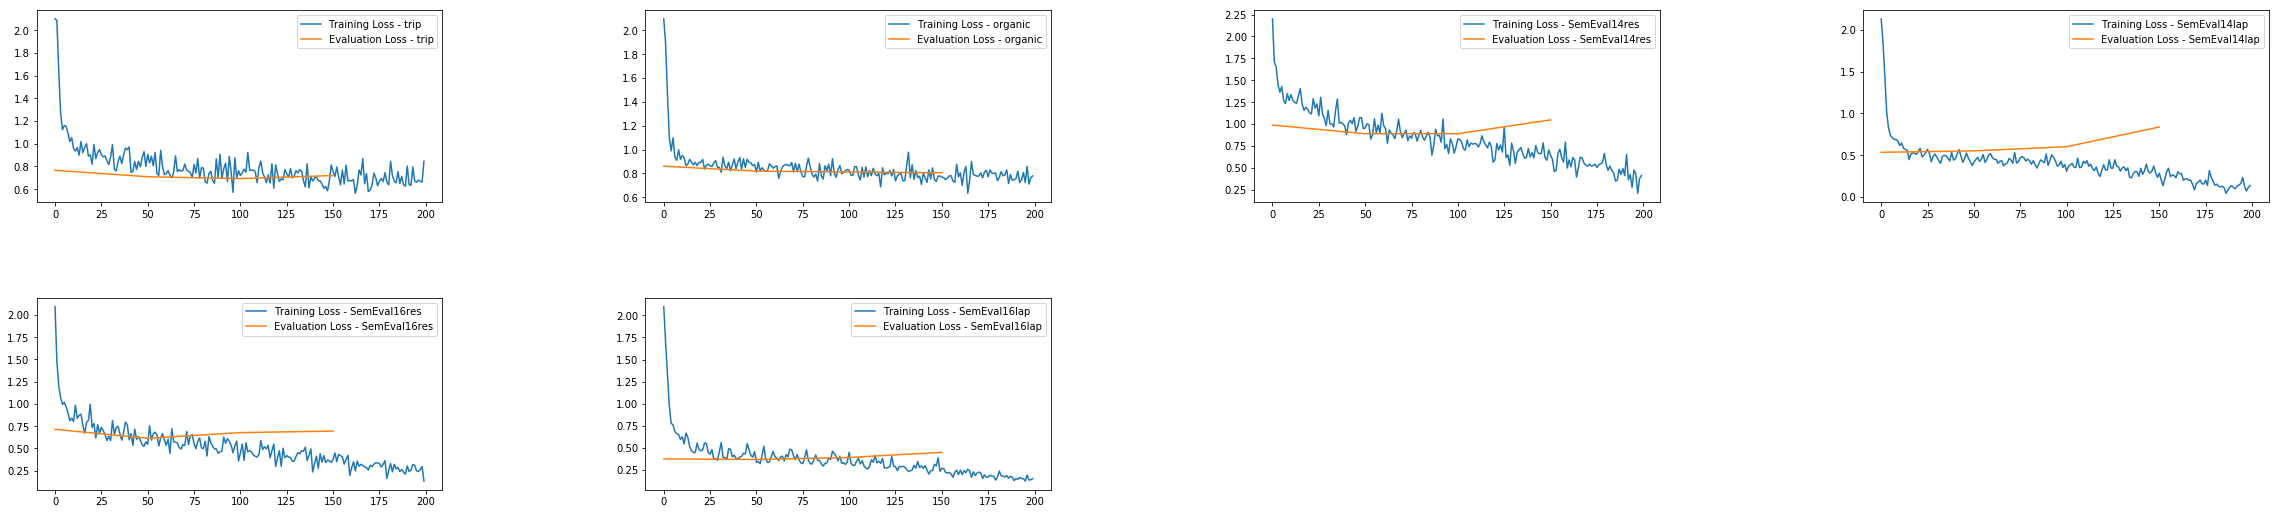

In [0]:
#Training process

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


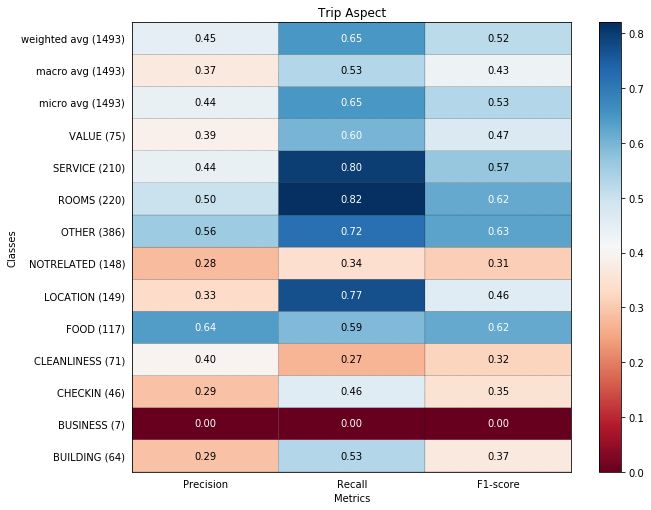

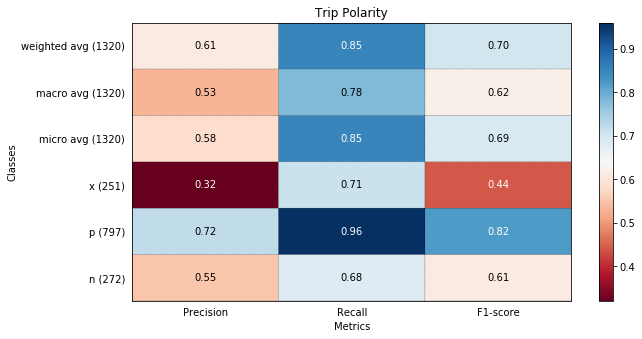

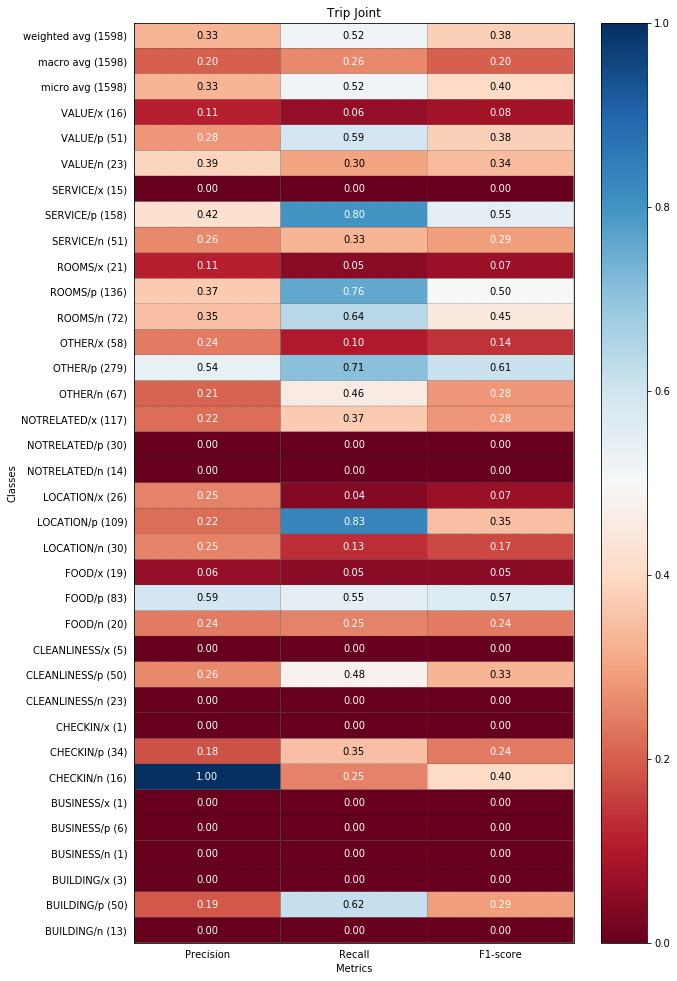

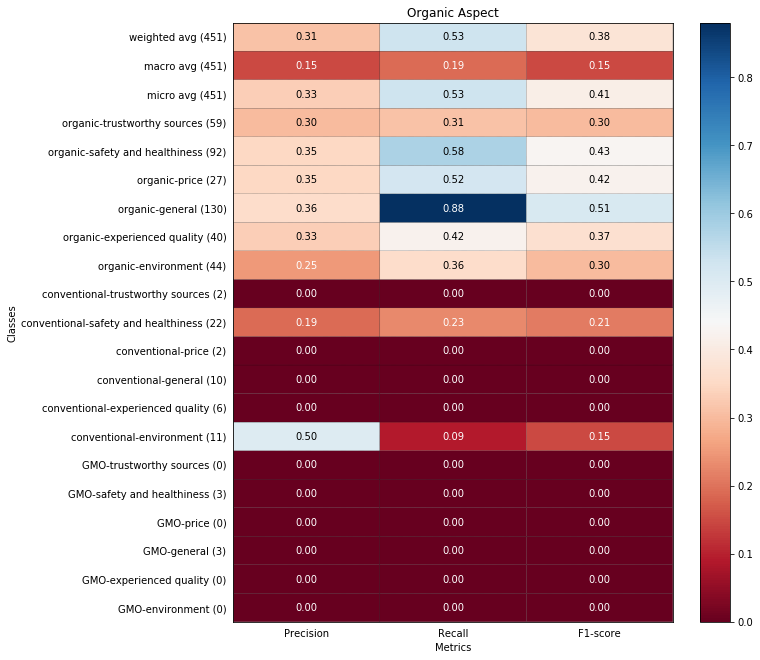

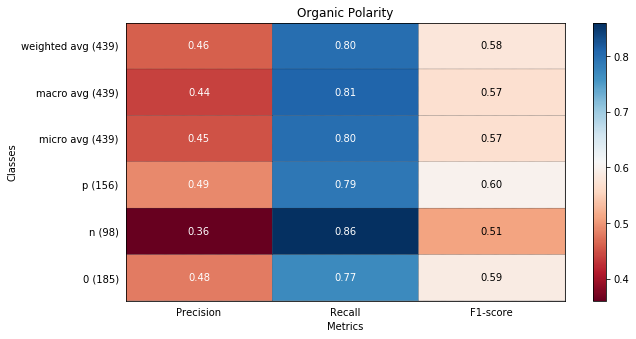

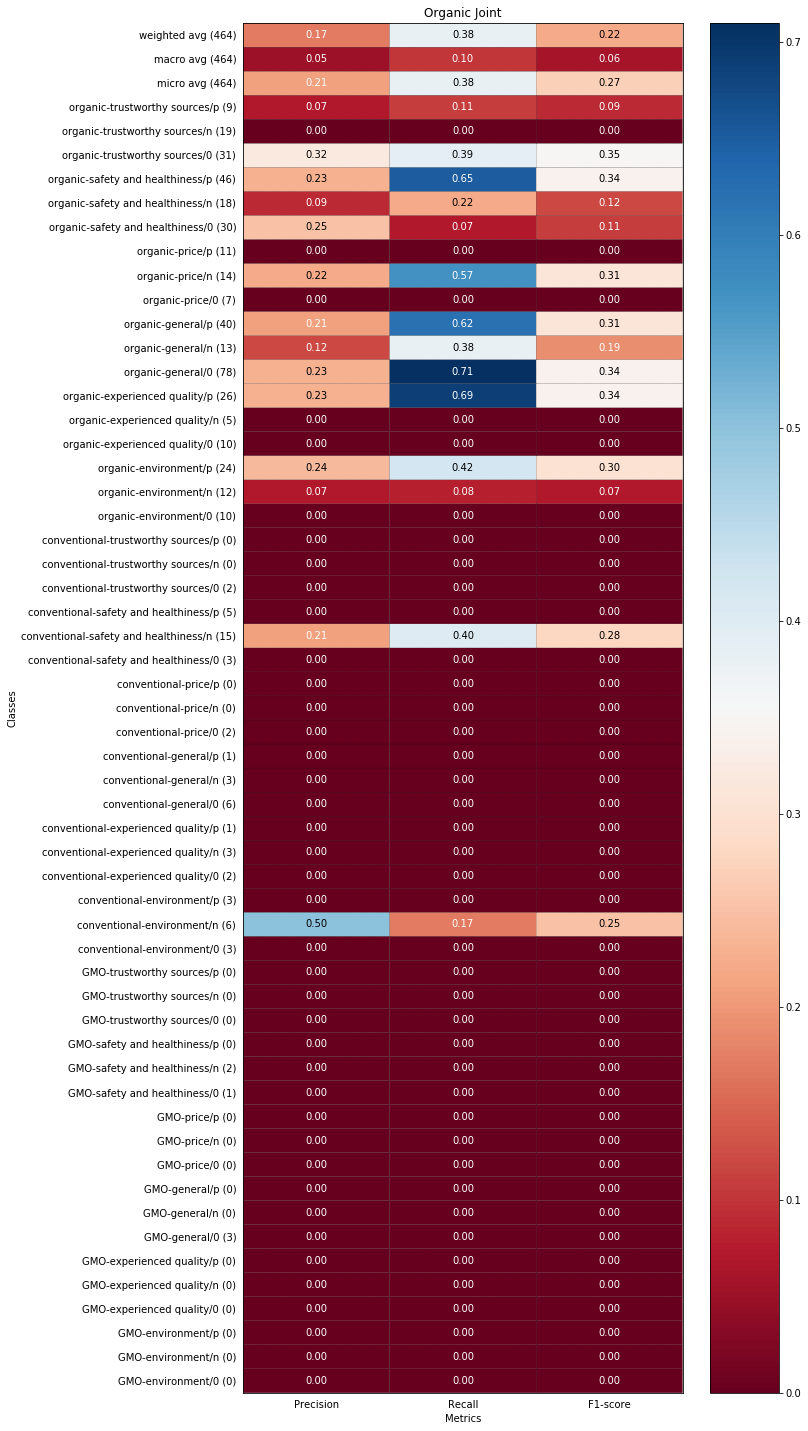

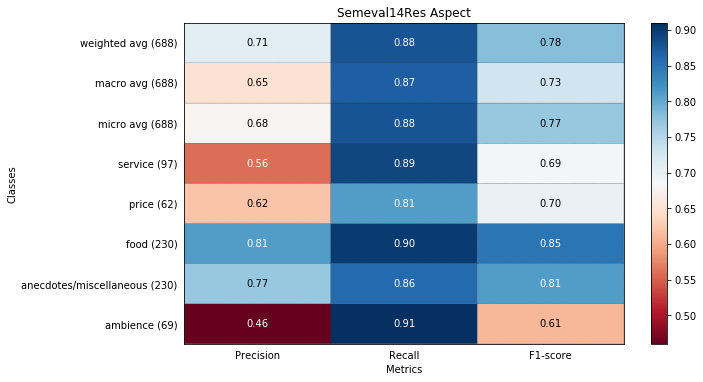

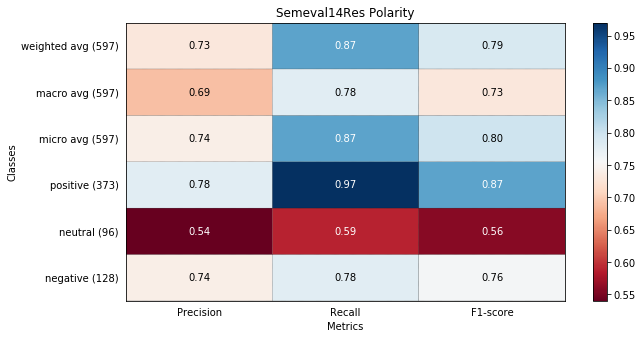

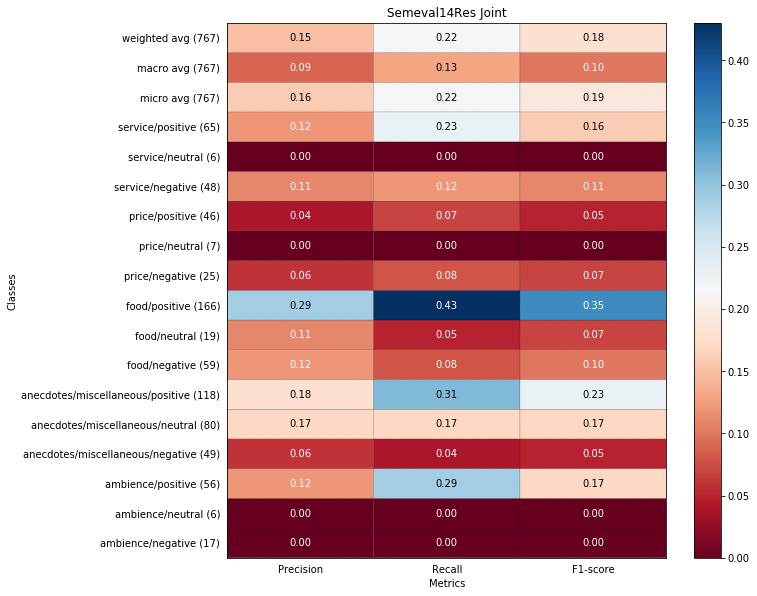

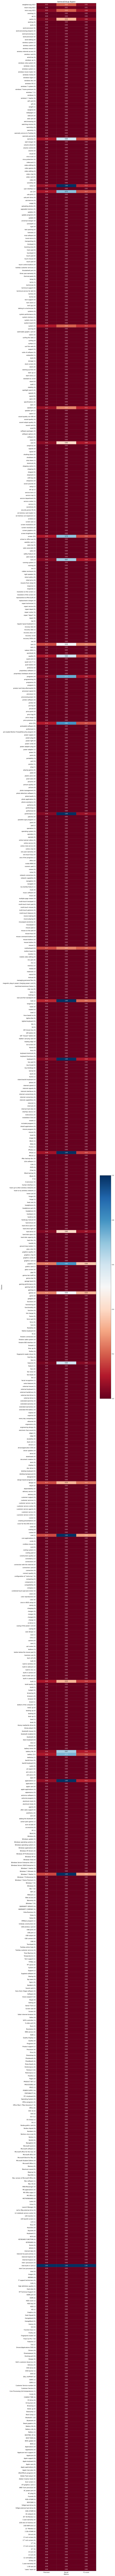

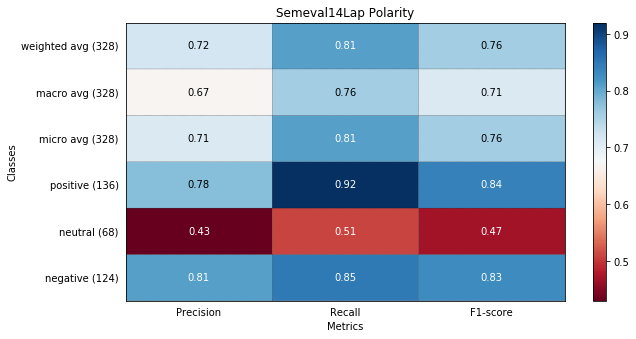

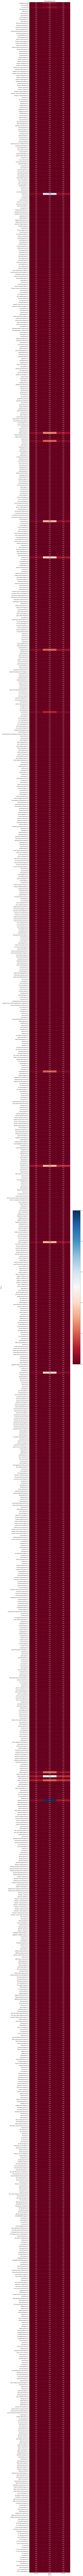

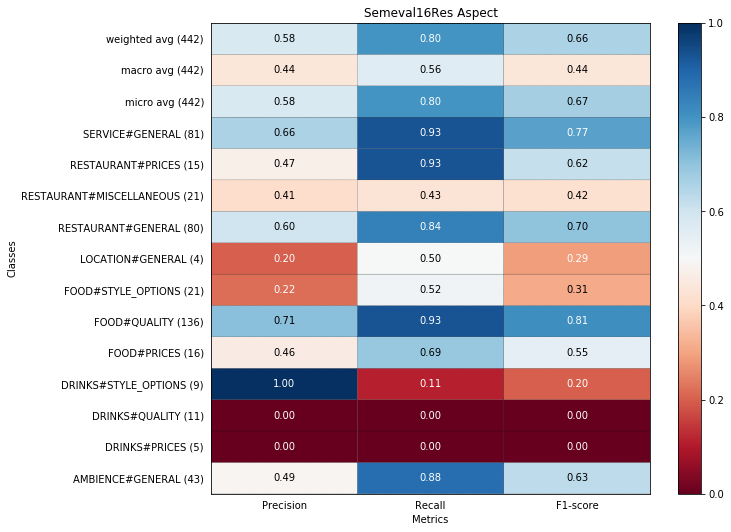

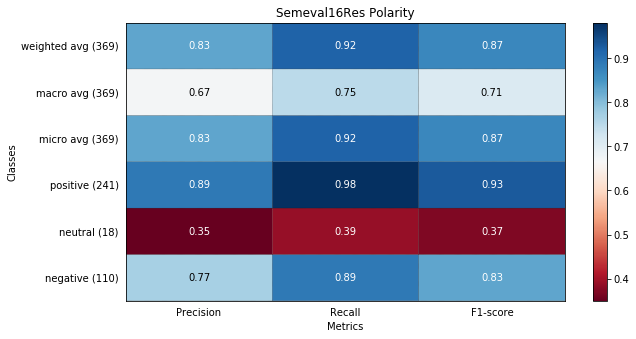

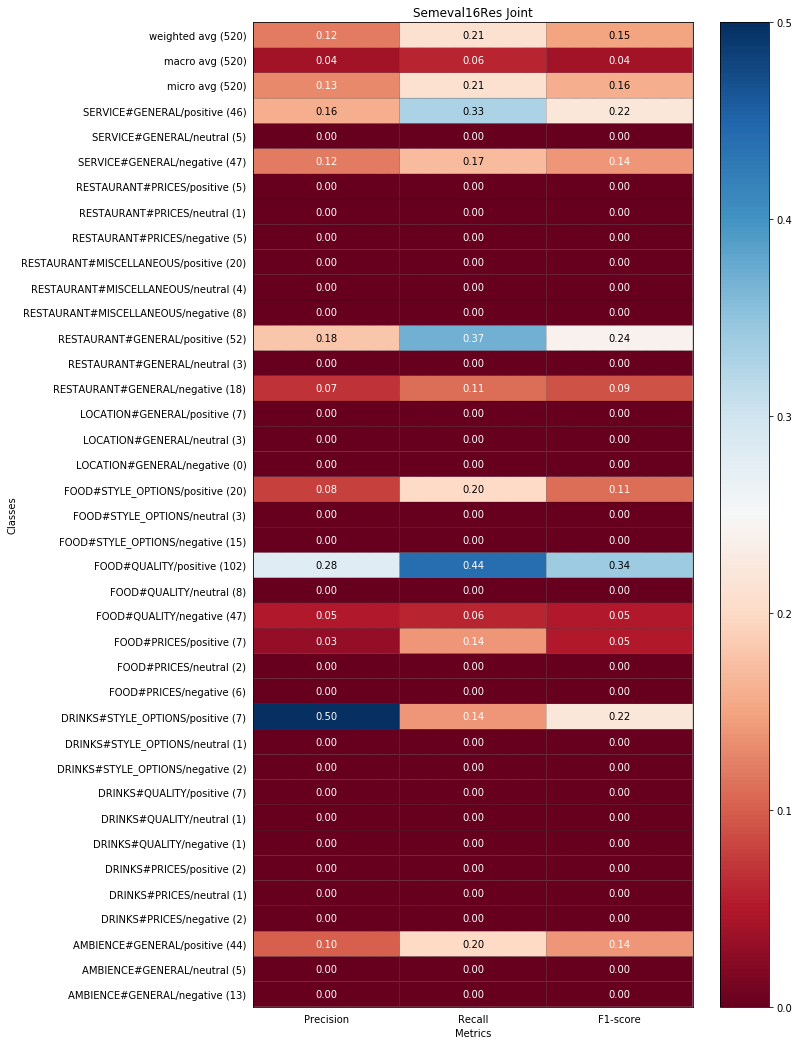

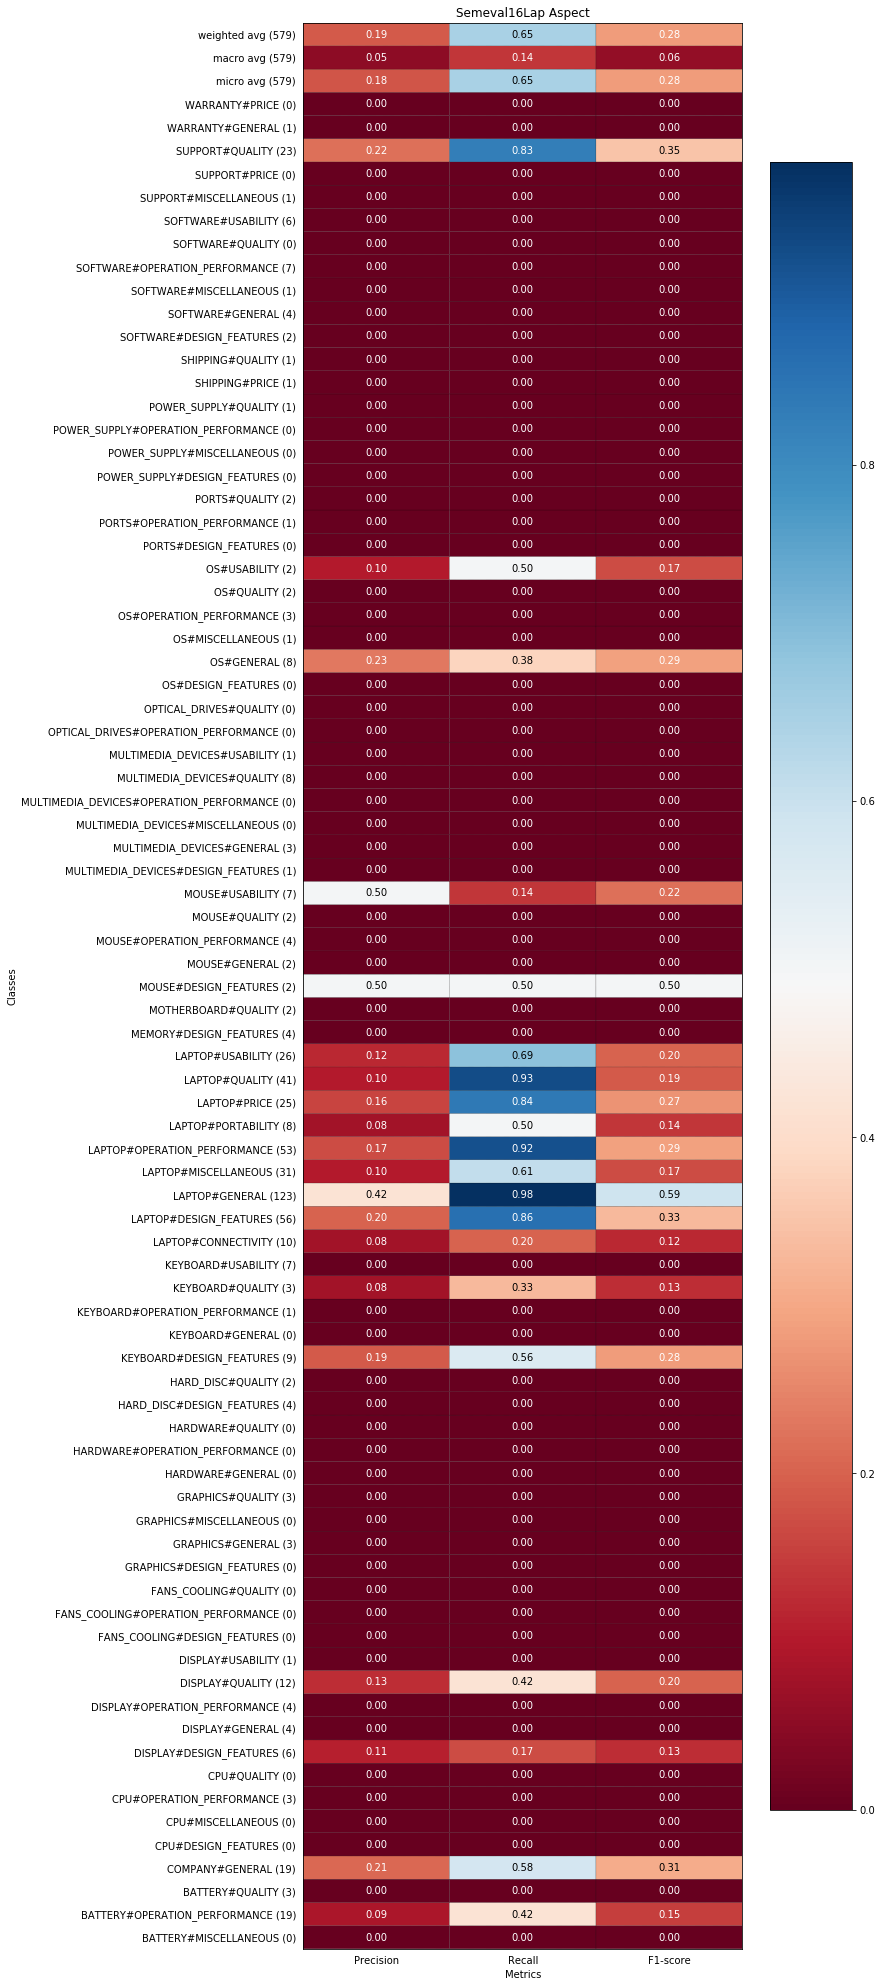

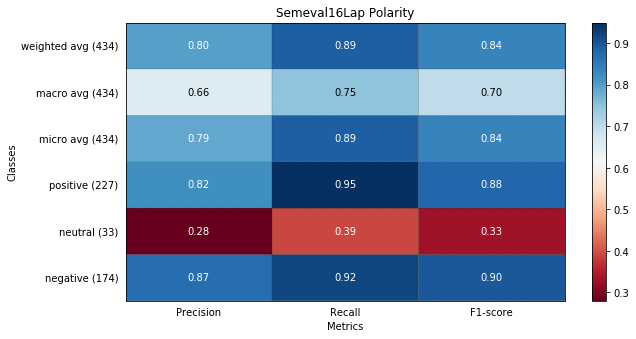

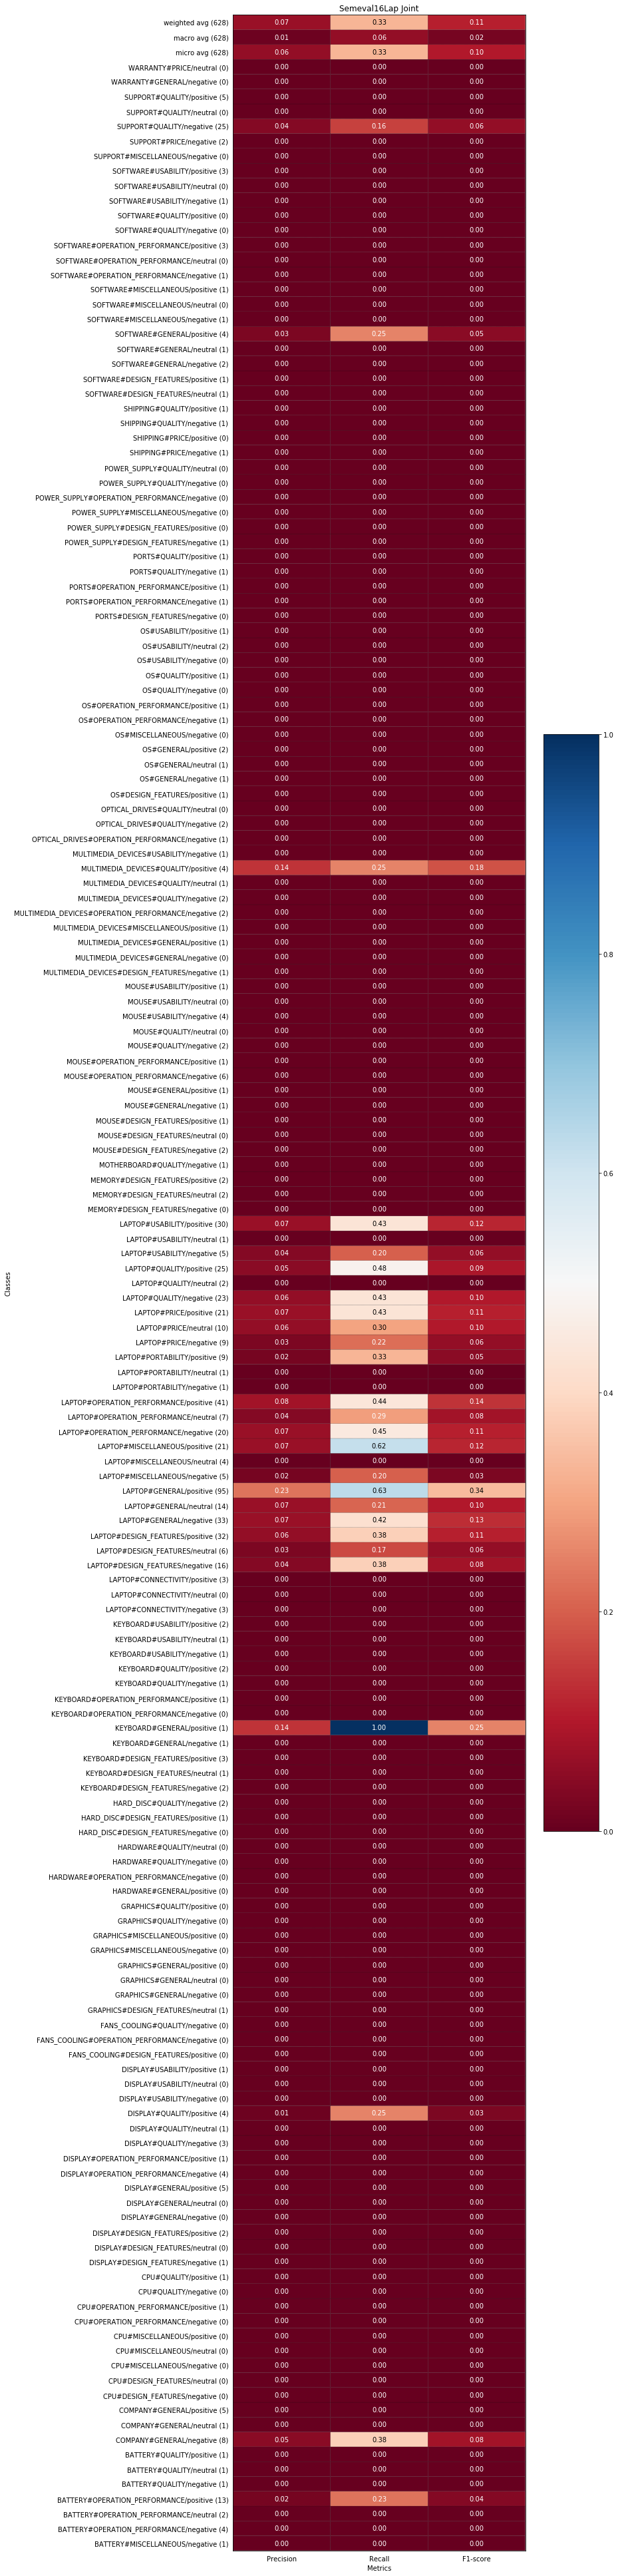

In [0]:
#Prediction Results